<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
* [Einleitung](#1) <font color='green'>Alice</font>
* [Package- und Datenimport](#2) <font color='green'>Alice</font>
* [Deskriptive Analyse](#3)
    * [Datenüberblick](#3.1) <font color='green'>Alice</font>
    * [Datentypen](#3.2) <font color='orange'>Alice</font>
    * [Betrachtung der Verteilung](#3.3) <font color='orange'>Alice</font>
    * [Analyse der Kategorischen Variablen](#3.4) <font color='red'>Not started</font>
    * [Zeitreihenanalyse](#3.5) <font color='green'>Niklas</font>
    * [Korrelationen](#3.6) <font color='orange'>In Progress</font>
    * [Fehlende Werte und Ausreißer:](#3.7) <font color='orange'>In Progress</font>
* [Daten anpassen](#4) <font color='red'>Not started</font>
* [Geeignete Merkmale](#4) <font color='red'>Not started</font>
* [ML Verfahren 1](#5) <font color='red'>Not started</font>
* [ML Verfahren 2](#6) <font color='red'>Not started</font>
* [Vergleich](#7) <font color='red'>Not started</font>

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

Alle verwendeten Quellen werden entsprechend referenziert. Die Nutzung von KI-gestützten Tools ist für dieses Projekt erlaubt und alle Schritte, einschließlich der Prompts, werden dokumentiert.

## 2. Package- und Datenimport <a id="2"></a> <br>

In [1]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white') # Hintergrund der Plots

In [2]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

## 3. Deskriptive Analyse <a id="3"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.


In [3]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\nikla\AppData\Local\Temp\ipykernel_820\2068288085.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


### 3.1 Datenüberblick <a id="3.1"></a> <br>

Kurzbeschreibung der Spalten der Train-, Test- und Store-Datensätze.

| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format) |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja).|
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").|

**Train-Datensatz Datenüberblick**

In [4]:
display(train.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Test-Datensatz Datenüberblick**

In [5]:
display(test.head())

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Store-Datensatz Datenüberblick**

In [6]:
display(store.head())

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.2 Datentypen <a id="3.2"></a> <br>

Neue Spalten
| Originale Spalte              | Neue Spalte                           | Beschreibung                                                              |
|-------------------------------|---------------------------------------|---------------------------------------------------------------------------|
| `Datum`                          | `Tag`                              | Gibt den Tag aus der ursprünglichen Spalte Datum an (von 1 bis 31).       |
| `Datum`                          | `Monat`                            | Gibt den Monat aus der ursprünglichen Spalte Datum an (von 1 bis 12).     |
| `Datum`                          | `Jahr`                             | Gibt das Jahr aus der ursprünglichen Spalte Datum an.             	    |
| `Datum`                          | `Quartal`                          | Gibt das Quartal aus der ursprünglichen Spalte Datum an (von 1 bis 4).    |

In [7]:
# Datentypen vor Korrektur
train_x_store.dtypes

Filiale                                int64
Wochentag                              int64
Datum                                 object
Umsatz                                 int64
Kundenanzahl                           int64
Geoeffnet                              int64
Aktionstag                             int64
Feiertag                              object
Schulferien                            int64
Filialentyp                           object
Sortiment                             object
Wettbewerberentfernung               float64
Wettbewerber_Eroeffnet_seit_Monat    float64
Wettbewerber_Eroeffnet_seit_Jahr     float64
Teilnahme_Langzeitaktion               int64
Aktion_seit_Woche                    float64
Aktion_seit_Jahr                     float64
Aktionsmonate                         object
dtype: object

In [8]:
# bestehende Spalten anpassen
train_x_store["Datum"] = pd.to_datetime(train_x_store["Datum"])
train_x_store["Wochentag"] = train_x_store["Datum"].dt.weekday

# neue Spalten hinzufügen
train_x_store["Tag"] = train_x_store["Datum"].dt.day
train_x_store["Monat"] = train_x_store["Datum"].dt.month
train_x_store["Jahr"] = train_x_store["Datum"].dt.year
train_x_store["Quartal"] = train_x_store["Datum"].dt.quarter

In [9]:
# Datentypen nach Korrektur
display(train_x_store.dtypes)

Filiale                                       int64
Wochentag                                     int32
Datum                                datetime64[ns]
Umsatz                                        int64
Kundenanzahl                                  int64
Geoeffnet                                     int64
Aktionstag                                    int64
Feiertag                                     object
Schulferien                                   int64
Filialentyp                                  object
Sortiment                                    object
Wettbewerberentfernung                      float64
Wettbewerber_Eroeffnet_seit_Monat           float64
Wettbewerber_Eroeffnet_seit_Jahr            float64
Teilnahme_Langzeitaktion                      int64
Aktion_seit_Woche                           float64
Aktion_seit_Jahr                            float64
Aktionsmonate                                object
Tag                                           int32
Monat       

### 3.2 Betrachtung der Verteilung <a id="3.2"></a> <br>

**Train_x_Store-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [10]:
describe = train_x_store.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien,Umsatz,Kundenanzahl,...,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
dtypes,int64,int64,int64,object,float64,int64,object,int64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209,1017209.0,1.017209e+06,1.017209e+06,...,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,855087,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,293122,NaN,NaN,NaN,NaN
mean,NaN,558.429727,2.998341,2014-04-11 01:30:42.846061824,0.830107,0.381515,NaN,0.178647,5.773819e+03,6.331459e+02,...,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN,1.570279e+01,5.846762e+00,2.013832e+03,2.294252e+00
min,NaN,1.0,0.0,2013-01-01 00:00:00,0.0,0.0,NaN,0.0,0.000000e+00,0.000000e+00,...,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00
25%,NaN,280.0,1.0,2013-08-17 00:00:00,1.0,0.0,NaN,0.0,3.727000e+03,4.050000e+02,...,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN,8.000000e+00,3.000000e+00,2.013000e+03,1.000000e+00
50%,NaN,558.0,3.0,2014-04-02 00:00:00,1.0,0.0,NaN,0.0,5.744000e+03,6.090000e+02,...,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN,1.600000e+01,6.000000e+00,2.014000e+03,2.000000e+00
75%,NaN,838.0,5.0,2014-12-12 00:00:00,1.0,1.0,NaN,0.0,7.856000e+03,8.370000e+02,...,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN,2.300000e+01,8.000000e+00,2.014000e+03,3.000000e+00


### 3.3 Analyse der Kategorischen Variablen <a id="3.3"></a> <br>

- Häufigkeitsverteilungen: Anzahl der Vorkommen jeder Kategorie (z.B. Anzahl der Filialen, Wochentage, Promotion-Typen).
- Balkendiagramme: Grafische Darstellung der Häufigkeiten.

### 3.4 Zeitreihenanalyse <a id="3.4"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

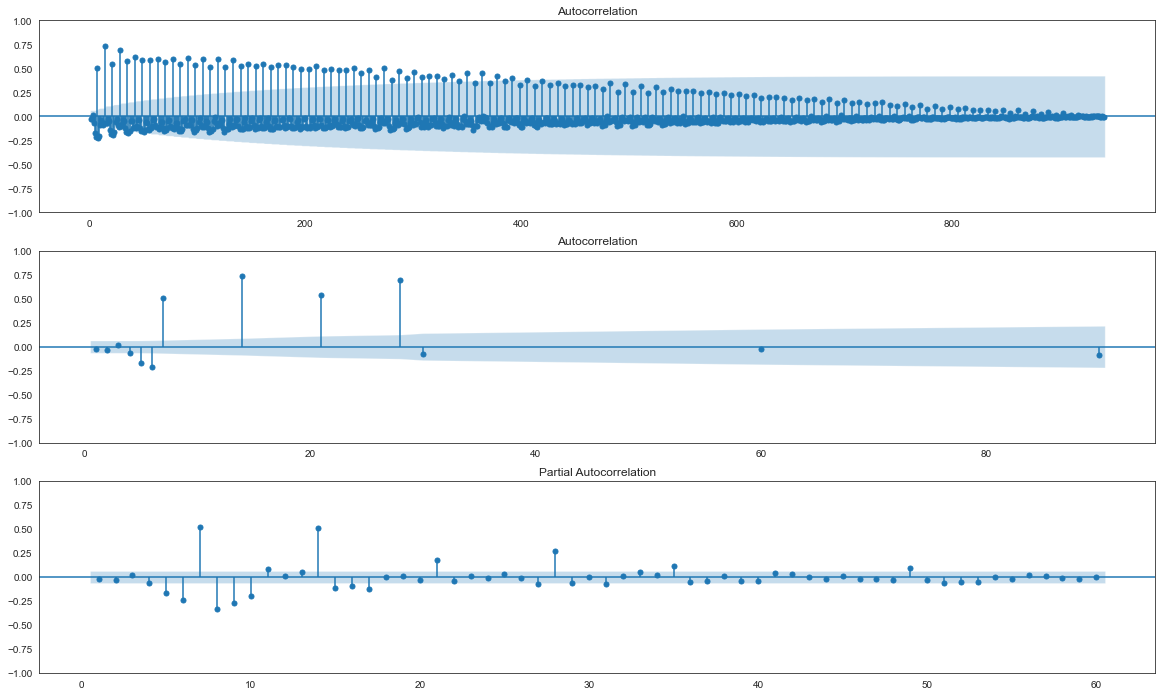

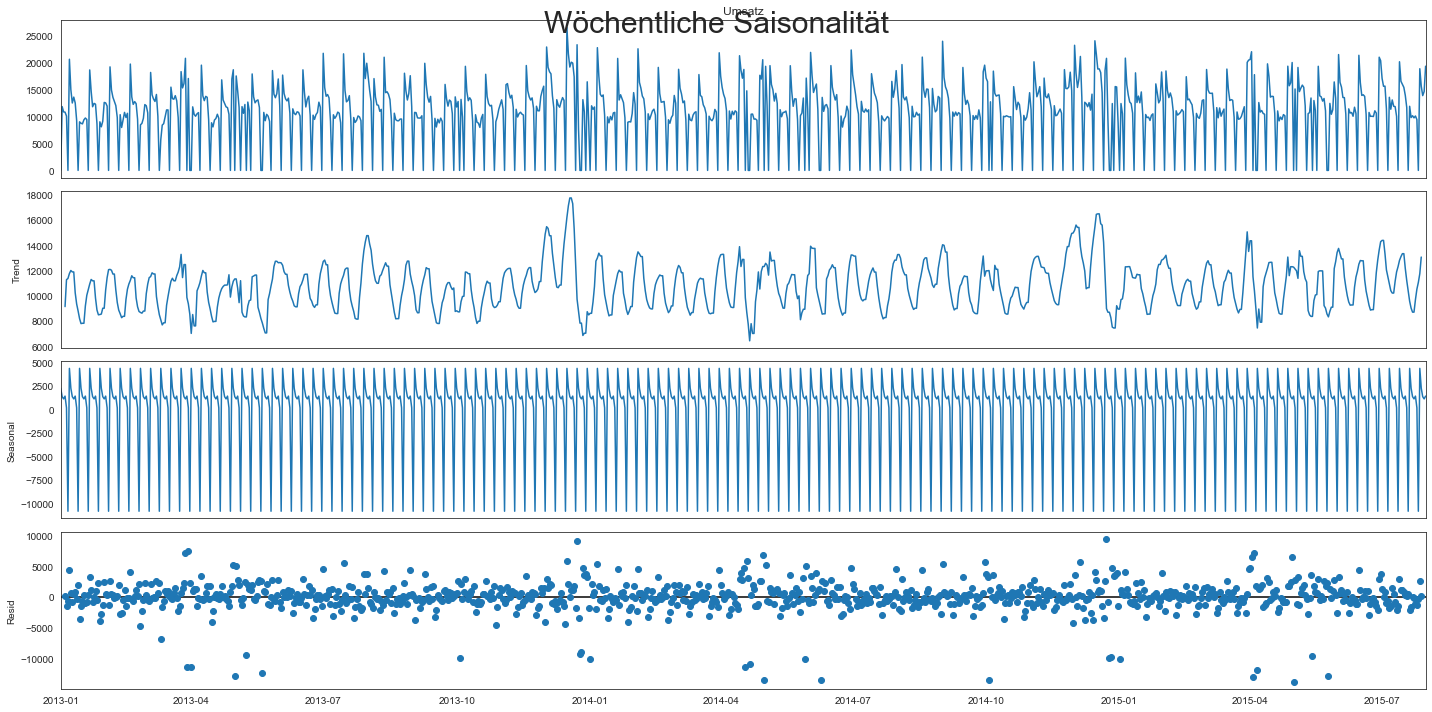

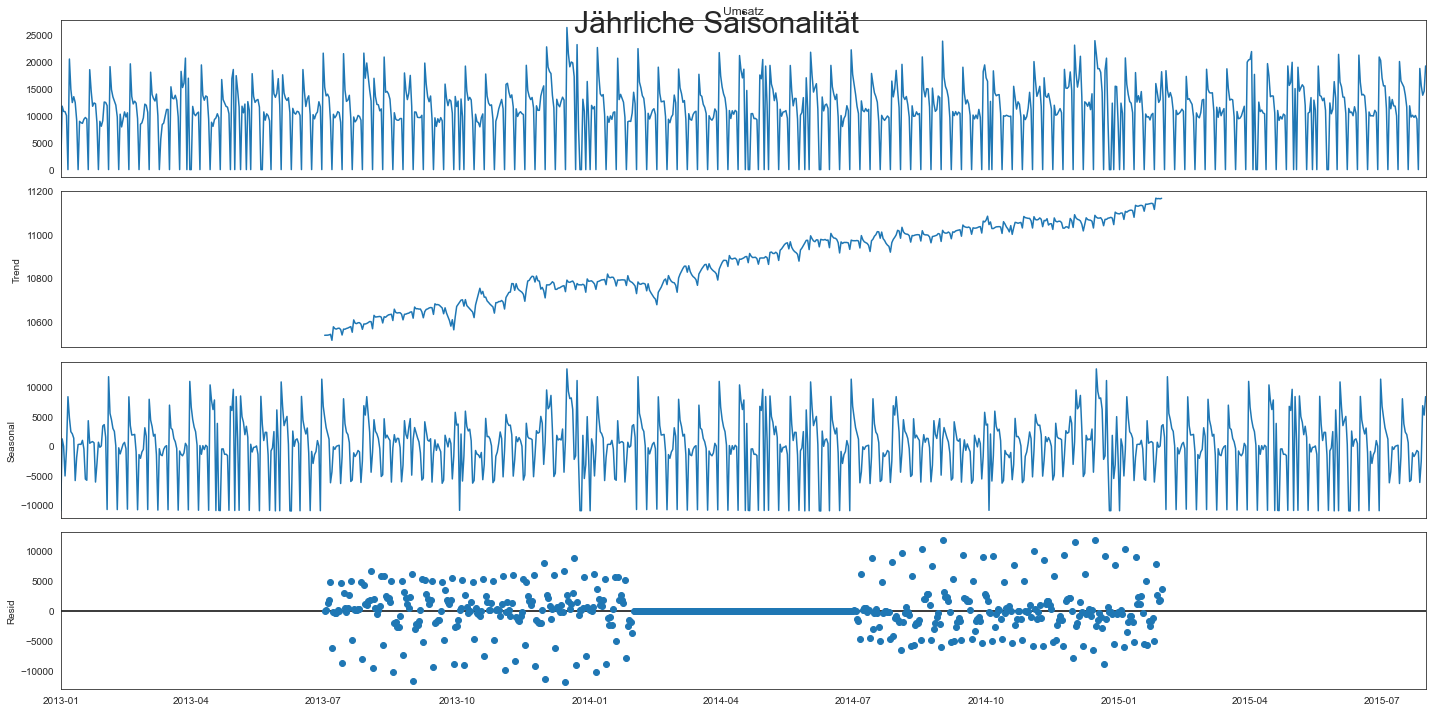

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

store_id = store["Filiale"].sample(n=1).values[0]
# store_id = 200
sample = train[train["Filiale"]==store_id].copy()
sample["Datum"] = pd.to_datetime(sample["Datum"])
sample.set_index("Datum", inplace = True, drop = True)
sample.sort_index(inplace = True)

# display(sample)
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 60, 90]

fig, axs = plt.subplots(3, figsize= (20,12))
plot_acf(sample["Umsatz"], lags = len(sample)-1, zero = False, ax = axs[0])
plot_acf(sample["Umsatz"], lags = lags, zero = False, ax = axs[1])
plot_pacf(sample["Umsatz"], lags = 60, zero = False, ax = axs[2])

stl_weekly_umsatz = seasonal_decompose(sample["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität', fontsize=30)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität', fontsize=30)
plt.show()


Der Umsatz weisen eine Autokorrelation zu Vielfachen von sieben auf, was darauf schließen lässt, dass der Umsatz vom Wochentag abhängig sind. Die Autokorrelation gibt keinen Hinweis auf andere zeitliche Einflüsse auf den Umsatz. Bei einer Aufschlüsselung der Daten über die Zeit sind jedoch wiederkehrende Spitzen im Trend zu beobachten. 

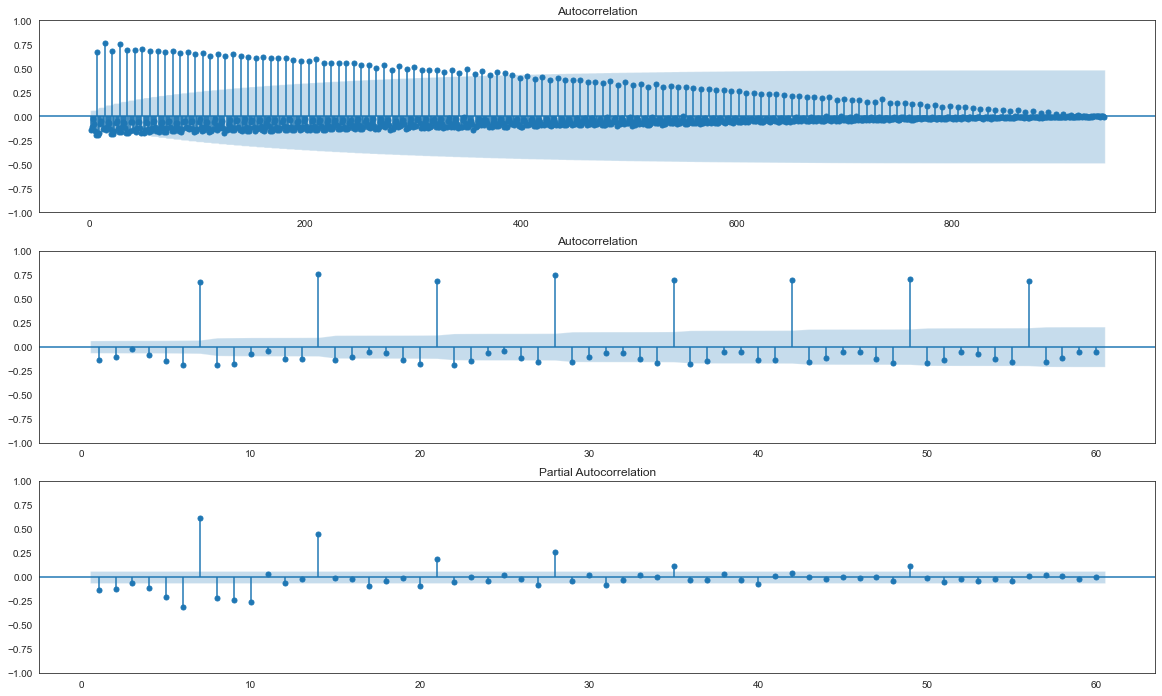

In [12]:
fig, axs = plt.subplots(3, figsize= (20,12))
plot_acf(sample["Kundenanzahl"], lags = len(sample)-1, zero = False, ax = axs[0])
plot_acf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[1])
plot_pacf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[2])

plt.show()

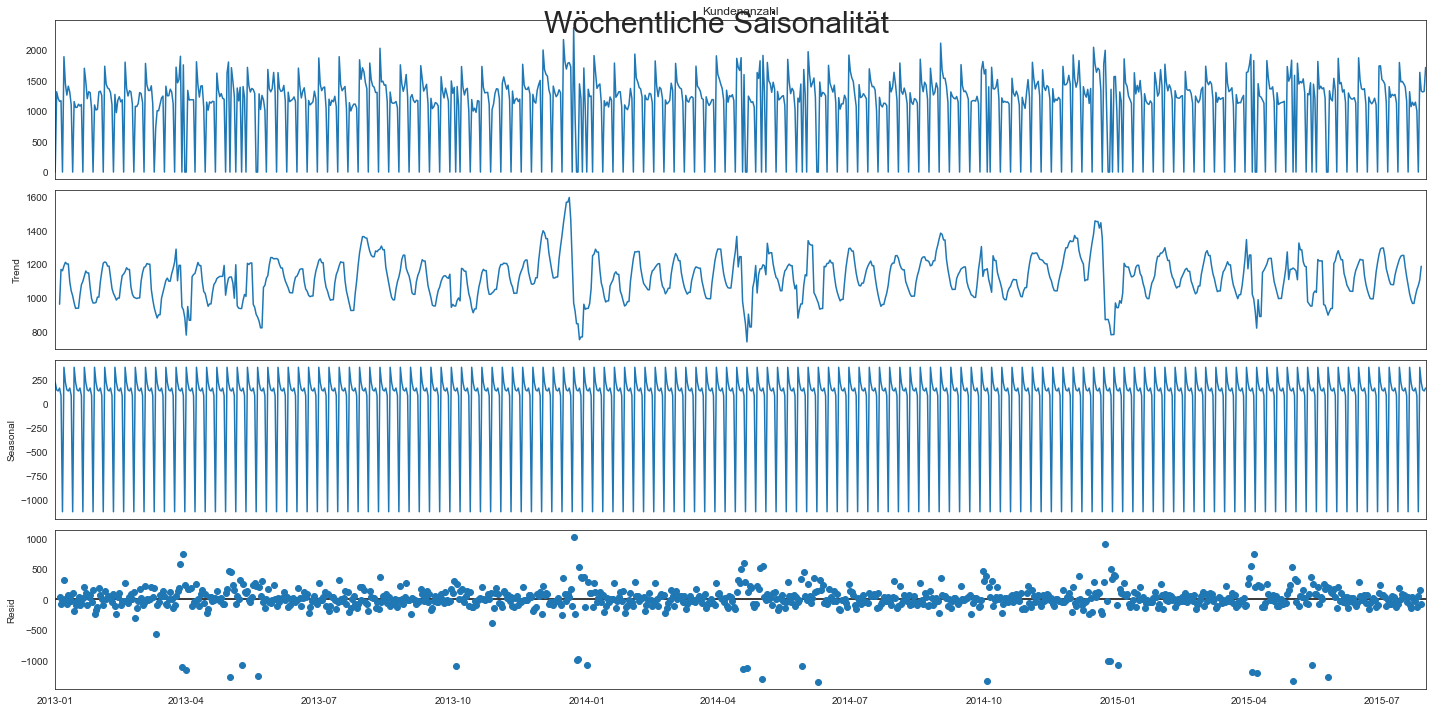

In [13]:
stl_weekly_kundenzahl = seasonal_decompose(sample["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität', fontsize=30)

plt.show()

### 3.5 Korrelationsanalyse <a id="3.5"></a> <br>

- Korrelationsmatrix: Untersuchung der Beziehungen zwischen numerischen Variablen, z.B. Umsatz und Anzahl der Kunden.
- Heatmaps: Visuelle Darstellung der Korrelationen.

In [14]:
train_x_store.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,...,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015,3
1,1,3,2015-07-30,5020,546,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,30,7,2015,3
2,1,2,2015-07-29,4782,523,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,29,7,2015,3
3,1,1,2015-07-28,5011,560,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,28,7,2015,3
4,1,0,2015-07-27,6102,612,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,27,7,2015,3


Die Korrelationsmatrix beinhaltet alle numerischen Spalten aus dem _train_x_store_ Datensatz. Dabei wird bei der Pearson-Korrelation mit binären Variablen genauso wie mit kontinuierlichen Variablen umgegangen.

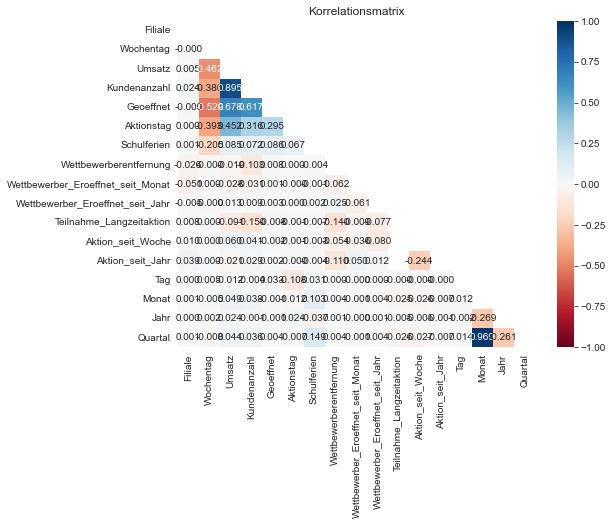

In [15]:
# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
train_x_store_only_nr = train_x_store.select_dtypes(include=['number'])

# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix = train_x_store_only_nr.corr("pearson")

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix")
plt.show()

### 3.6 Fehlende Werte und Ausreißer <a id="3.6"></a> <br>

- Fehlende Werte: Identifikation und Quantifizierung von fehlenden Datenpunkten.
- Ausreißer: Identifikation von ungewöhnlich hohen oder niedrigen Werten, die nicht dem allgemeinen Muster folgen.

In [16]:
round(train.isnull().sum() / train.shape[0] *100, 2) #Prozent

Filiale         0.0
Wochentag       0.0
Datum           0.0
Umsatz          0.0
Kundenanzahl    0.0
Geoeffnet       0.0
Aktionstag      0.0
Feiertag        0.0
Schulferien     0.0
dtype: float64

#### Datentypen anpassen

In [17]:
dtypes_dict = {"Geoeffnet": bool,
               "Aktionstag": bool,
               "Feiertag": bool,
               "Schulferien": bool}

In [18]:
# Datentypen im Train-Datensatz ändern
train = train.astype(dtypes_dict)
train["Datum"] = pd.to_datetime(train["Datum"])
#train["Wochentag"] = train["Datum"].dt.weekday # Montag=0, Sonntag=6

# Check
print("\nTrain-Datensatztypen nachher")
display(train.dtypes)


Train-Datensatztypen nachher


Filiale                  int64
Wochentag                int64
Datum           datetime64[ns]
Umsatz                   int64
Kundenanzahl             int64
Geoeffnet                 bool
Aktionstag                bool
Feiertag                  bool
Schulferien               bool
dtype: object

#### Tage ohne Umsatz betrachten

Gibt es Datensätze mit 0€ Umsatz? Wenn ja, wann und wieso ist das so?

In [19]:
display(train[train.Umsatz==0.0])

kein_umsatz_anzahl = train[train.Umsatz==0.0].shape[0]

print(str(kein_umsatz_anzahl) + " von " + str(train.shape[0]) + " Zeilen (" + str(round(kein_umsatz_anzahl/train.shape[0]*100,2)) + "%) haben keinen Umsatz.")


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
291,292,5,2015-07-31,0,0,False,True,True,True
875,876,5,2015-07-31,0,0,False,True,True,True
1406,292,4,2015-07-30,0,0,False,True,True,True
1990,876,4,2015-07-30,0,0,False,True,True,True
2521,292,3,2015-07-29,0,0,False,True,True,True
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,False,False,True,True
1017205,1112,2,2013-01-01,0,0,False,False,True,True
1017206,1113,2,2013-01-01,0,0,False,False,True,True
1017207,1114,2,2013-01-01,0,0,False,False,True,True


172871 von 1017209 Zeilen (16.99%) haben keinen Umsatz.


Wir nehmen uns eine zufällige Filiale und schauen uns an, wann kein Umsatz gemacht wurde

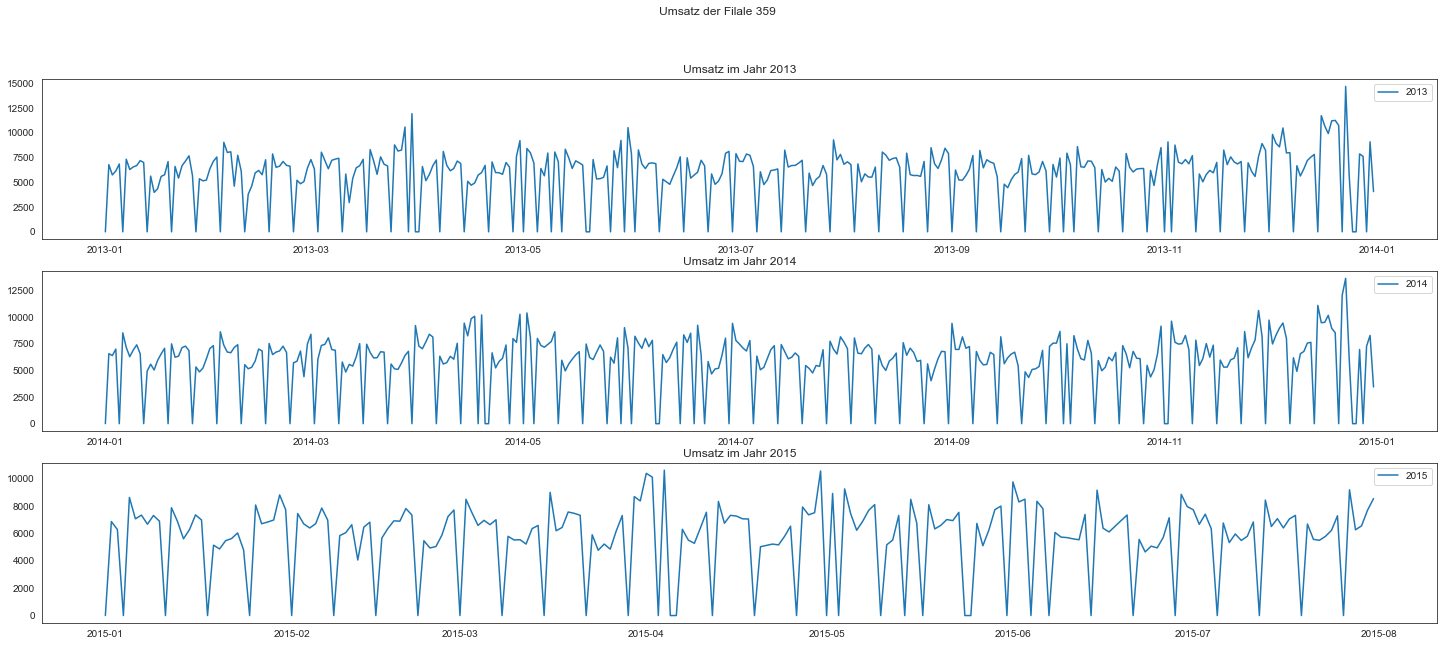

In [20]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train[train["Filiale"]==store_id].copy()
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)

fig, axs = plt.subplots(3)
fig.set(figheight = 10, figwidth = 25)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

In [21]:
# Alle Tage, an denen kein Umsatz gemacht wurde, obwohl die Filiale geöffnet war
kein_umsatz_geoeffnet = train[(train["Umsatz"]==0) & (train["Geoeffnet"]==True)]
kein_umsatz_geoeffnet.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
86825,971,5,2015-05-15,0,0,True,False,True,True
142278,674,4,2015-03-26,0,0,True,False,True,False
196938,699,4,2015-02-05,0,0,True,True,True,False
322053,708,3,2014-10-01,0,0,True,True,True,False
330176,357,1,2014-09-22,0,0,True,False,False,False


In [22]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

,,Anzahl_Tage,Umsatz
Wochentag,Geoeffnet,,
1,True,3,0
2,True,6,0
3,True,14,0
4,True,18,0
5,True,7,0
6,True,6,0


#### Leere Werte betrachten

## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## Machine Learning Verfahren 2 <a id="6"></a> <br>

## Vergleich der Machine Learning Verfahren <a id="7"></a> <br>